In [184]:
## FX Conventions ##

USDTWD = 28.53
# ccy1 foreign currency or base currency 
# ccy2 domestic currency
# ccy1ccy2 = Number of units of ccy2 required to buy ccy1. Number of units of ccy2 per ccy1

# GBPUSD = 1.6395
# Number of units of USD required to by GBP. Need 1.6395 USD to buy 1 GBP
# 1.6395 -> Read: 1 SPOT 6395. USDJPY = 92.00. -> Read : 92 figure 
# XAUDUSD = 1951.00 -> 1951 USD to buy 1 once of GOLD

In [185]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

In [186]:
def d12(S0,K,rd,rf,sigma,T):
    d1 = (math.log(S0/K) + (rd - rf + 0.5*sigma**2) * T)/ (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return (d1,d2)

def d12_fwd(F0,K,sigma,T):
    d1 = (math.log(F0/K) + (0.5*sigma**2) * T)/ (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return (d1,d2)

# theorical value of european option in basic BSM
# option to exchange K units of domestic (ccy2) for 1 unit of foreign (ccy1) expressed in domestic (ccy2)
# ccy2/ccy1 price (or domestic pips)
def option(S0,K,rd,rf,sigma,T,is_call=True):
    (d1,d2) = d12(S0,K,rd,rf,sigma,T)
    w = (-1, 1)[is_call]
    return w * S0 * math.exp(-rf*T)*norm.cdf(w*d1) - w*K*math.exp(-rd*T)*norm.cdf(w*d2)

def option_fwd(F0,K,rd,sigma,T,is_call=True):
    (d1,d2) = d12_fwd(F0,K,sigma,T)
    w = (-1, 1)[is_call]
    return w*math.exp(-rd*T)*(F0*norm.cdf(w*d1)-K*norm.cdf(w*d2))

def pips_spot_delta(F0,K,rf,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    (d1,_) = d12_fwd(F0,K,sigma,T)
    return w * math.exp(-rf*T)*norm.cdf(w*d1)

def pips_fwd_delta(F0,K,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    (d1,_) = d12_fwd(F0,K,sigma,T)
    return w *norm.cdf(w*d1)



# Quotes https://www.investing.com/currencies/eur-usd-options


EURUSD = 1.1880
fwd_1m = 7.615 / 10_000 
EURUSD_1m = EURUSD + fwd_1m
K = 1.19
notional = 1_000_000

eur_r = -0.57486 / 100
usd_r = 0.14463 / 100

# Vd/f
usd_pips = option(EURUSD,K=K,rd=usd_r,rf = eur_r,sigma=0.0705,T=30/365,is_call=True)
usd_pips_fwd = option_fwd(EURUSD_1m,K=K,rd=usd_r, sigma=0.0705,T=30/365,is_call=True)

usd_pips_market = 0.00908 # premium in USD to buy EUR at 1.19 in 1 months  
eur_pips = usd_pips / (EURUSD*K) # Vf/d = Vd/f / (spot*K)
eur_perc = usd_pips_market / EURUSD # V%f = Vd/f / spot
usd_perc = usd_pips_market / K # V%f = Vd/f / spot

# Number of units of foreign currency we need to hold in order to hedge option 
# with notional of 1 foreign currency and K domestic currency
usd_pips_spot_delta = pips_spot_delta(EURUSD_1m,K=K,rf=eur_r, sigma=0.0705,T=30/365,is_call=True)
usd_pips_fwd_delta = pips_fwd_delta(EURUSD_1m,K=K, sigma=0.0705,T=30/365,is_call=True)

# usd_pips
# usd_pips_fwd
# usd_pips_market
# eur_pips
usd_pips_spot_delta
usd_pips_fwd_delta

0.4837115544712757

0.48348306070984853

In [187]:
USDEUR = 1 / EURUSD
eur_pips = option(USDEUR,K=1/1.19,rf=usd_r,rd = eur_r,sigma=0.0704,T=30/365,is_call=False)
eur_pips

0.006324189748032172

In [188]:
eurusd_df = pd.DataFrame([['1M',0.21,0.0065,0.02433,-0.002,-0.01258],
                         ['2M',0.21,0.0075,0.0283,-0.0025,-0.01297],
                         ['3M',0.2075,0.0085,0.03228,-0.003,-0.01332],
                         ['6M',0.194,0.009,0.03485,-0.005,-0.01408],
                         ['1Y',0.1825,0.0095,0.03806,-0.006,-0.01359],
                         ['2Y',0.17677,0.0085,0.03208,-0.00562,-0.01208]], columns = ['Tenor', 'ATMVol','25dMS','10dMS','25dRR','10dRR'])

def ATM_DNS_pips(F0,sigma,T):
    return F0*math.exp(0.5*sigma**2*T)

def ATM_DNS_perc(F0,sigma,T):
    return F0*math.exp(-0.5*sigma**2*T)

def delta_to_strike(F0,delta,rf,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    return F0*math.exp(-w*norm.ppf(w*math.exp(rf*T)*delta)*sigma*math.sqrt(T)+0.5*sigma**2*T)

ATM_DNS_pips = ATM_DNS_pips(EURUSD_1m,0.0705,30/365)
# pips_spot_delta of the straddle at ATM_DNS_pips is indeed 0
DNS_delta = pips_spot_delta(EURUSD_1m,ATM_DNS_pips,eur_r,0.0705,30/365,is_call=True) + pips_spot_delta(EURUSD_1m,ATM_DNS_pips,eur_r,0.0705,30/365,is_call=False)
DNS_delta # should be 0
# ATM Vol + 25d market strangle premium in vol points
K_call_25 = delta_to_strike(1.3395,0.25,0.0346,0.1920,1,is_call=True)
K_put_25 = delta_to_strike(1.3395,-0.25,0.0346,0.1920,1,is_call=False)
K_call_25
K_put_25



-4.440892098500626e-16

1.544902905771743

1.2050195077199684

In [220]:
def IV_SABR(K,F0,T,alpha,vov,rho,beta=1):
    
    def z(F0,K,alpha,beta,vov):
        z = vov/alpha
        z = z* (F0*K)**((1-beta) / 2)
        z = z * math.log(F0/K)
        return z
    
    def chi(z,rho):
        return math.log((math.sqrt(1-2*rho*z+z**2) + z - rho) / (1-rho))
    
    A = (F0*K)**((1-beta)/2)
    
    B1 = ((1-beta)**2)/24
    B1 = B1 * math.log(F0/K)**2
    B2 = ((1-beta)**4)/1920
    B2 = B2 * math.log(F0/K)**4

    B = 1 + B1 + B2
    
    z = z(F0,K,alpha,beta,vov)
    C = z / chi(z,rho)

    D1 = (1-beta**2)/24
    D1 = D1 * (alpha**2 / (F0*K)**(1-beta))
    D2 = 0.25*rho*beta*vov*alpha / ((F0*K)**((1-beta)/2))
    D3 = ((2-3*rho**2)/24)*vov**2
    D = 1 + (D1+D2+D3)*T
    return (alpha / (A*B))*C*D

19.49

19.47

18.25

18.89

18.93

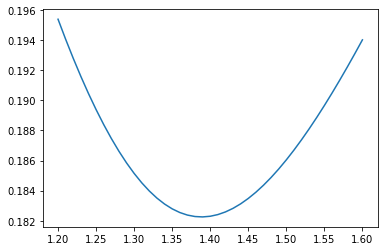

In [229]:
alpha = 0.17431060
vov=0.81694072
rho=-0.11268306

spot = 1.3465
F0 = 1.3395
spot_range=np.arange(1.2,1.6,0.01)
vIV_SABR= np.vectorize(IV_SABR)
IV_range = vIV_SABR(spot_range,F0,1,alpha,vov,rho)
plt.plot(spot_range,IV_range)
round(100*IV_SABR(1.2034,F0,1,alpha,vov,rho),2)
round(100*IV_SABR(1.2050,F0,1,alpha,vov,rho),2)
round(100*IV_SABR(1.3620,F0,1,alpha,vov,rho),2)
round(100*IV_SABR(1.541,F0,1,alpha,vov,rho),2)
round(100*IV_SABR(1.5449,F0,1,alpha,vov,rho),2)

In [228]:
# inputs
F0 = 1.3395
T = 1
vol_ATM = 0.1825
vol_25d_MS = 0.0095
rf = 0.0346
rd = 0.0294

### Smile strangle from Market strangle

# 1. Decide on parametric form (here SABR)

# 2. Determine KATM by using either ATMF or ATM DNS depending on market convention
K_ATM = ATM_DNS_pips(F0,vol_ATM,T)

# 3. Use Vol ATM and vol Vol 25d MS to determine K 25d P MS and K 25d C MS
# ATM Vol + 25d market strangle premium in vol points
K_call_25 = delta_to_strike(F0,0.25,0.0346,vol_ATM + vol_25d_MS,T,is_call=True)
K_put_25 = delta_to_strike(F0,-0.25,0.0346,vol_ATM + vol_25d_MS,T,is_call=False)

# 4. Determine Price 25d MS
price_25d_MS = option_fwd(F0,K=K_call_25,rd=rd, sigma=vol_ATM + vol_25d_MS,T=T,is_call=True) + option_fwd(F0,K=K_call_25,rd=rd, sigma=vol_ATM + vol_25d_MS,T=T,is_call=False)

# 5. Choose an initial guess for vol 25d Smile Strangle , such as vol 25d SS = vol 25d MS

17.81

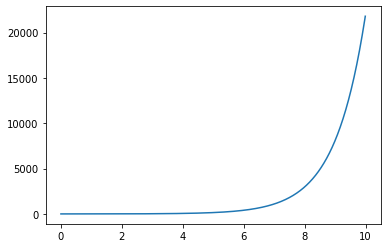

In [179]:
def f(x,T,co,c1,c2):
    return 1

x = np.arange(0,10,0.01)
F0 = 1
# y = np.sin(x)
c0 = 1
c1 = 1
c2 = 1
y = np.exp(x)
plt.plot(x,y)

In [180]:
y

array([1.00000000e+00, 1.01005017e+00, 1.02020134e+00, 1.03045453e+00,
       1.04081077e+00, 1.05127110e+00, 1.06183655e+00, 1.07250818e+00,
       1.08328707e+00, 1.09417428e+00, 1.10517092e+00, 1.11627807e+00,
       1.12749685e+00, 1.13882838e+00, 1.15027380e+00, 1.16183424e+00,
       1.17351087e+00, 1.18530485e+00, 1.19721736e+00, 1.20924960e+00,
       1.22140276e+00, 1.23367806e+00, 1.24607673e+00, 1.25860001e+00,
       1.27124915e+00, 1.28402542e+00, 1.29693009e+00, 1.30996445e+00,
       1.32312981e+00, 1.33642749e+00, 1.34985881e+00, 1.36342511e+00,
       1.37712776e+00, 1.39096813e+00, 1.40494759e+00, 1.41906755e+00,
       1.43332941e+00, 1.44773461e+00, 1.46228459e+00, 1.47698079e+00,
       1.49182470e+00, 1.50681779e+00, 1.52196156e+00, 1.53725752e+00,
       1.55270722e+00, 1.56831219e+00, 1.58407398e+00, 1.59999419e+00,
       1.61607440e+00, 1.63231622e+00, 1.64872127e+00, 1.66529119e+00,
       1.68202765e+00, 1.69893231e+00, 1.71600686e+00, 1.73325302e+00,
      

In [181]:
plot(x,y)

NameError: name 'plot' is not defined